In [31]:
from particle import Particle
from structure import Layer,Aluminum,Lead,Scintillator, Structure
import numpy as np
import matplotlib.pyplot as plt

fs = 19
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)
plt.rc('font', size=fs)          # controls default text sizes
plt.rc('axes', titlesize=fs)     # fontsize of the axes title
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels
plt.rc('legend', fontsize=fs-1)    # legend fontsize

In [9]:
# Creation of the detector

Al = Aluminum(1)
Pb = Lead(4)
Si = Scintillator(4)
detec_unit = Structure([Si,Al,Pb,Al])
detec = detec_unit.mult(16)

print(detec.top())


160


In [10]:
# Creation of the particle
import matplotlib.pyplot as plt

pos_init = np.array([0.,0.])
mass_mu = 105.7*10**6
energy_mu = 2*10**8
charge = -1
angle = np.pi/4
muon = Particle(charge,mass_mu,energy_mu,np.copy(pos_init),angle)
print(muon.beta())

mass_e = 511000
energy_e = mass_mu/3
electron = Particle(charge,mass_e,energy_e,np.copy(pos_init),angle)
print(electron.beta())




0.8489333012669488
0.9998948214500091


In [11]:
electron.print()

Charge =  -1 e
Mass =  511000 eV
Energy =  35233333.333333336 eV
Position =  [0. 0.] mm
Theta =  0.7853981633974483 rad


In [36]:
#function running the simulation
import copy
def propagation(part_model,detec,dx = 0.001, freq = 1, print_pos=False):
    part = copy.deepcopy(part_model)
    energies = [part.energy]
    x = np.copy(part.pos)
    counter = 1
    while part.energy > part.mass and part.pos[1] + dx*np.sin(part.theta) <= detec.top():
        part.pos += dx*np.array([np.cos(part.theta),np.sin(part.theta)]) 
        part.energy -= dx*0.001*detec.material(part.pos[1]-dx/2*np.sin(part.theta)).bethe_bloch(part.beta(),part.charge)
        if counter % freq == 0:
            counter = 0
            energies.append(part.energy)
            x = np.vstack((x,part.pos))

    if print_pos:
        if part.energy > part.mass:
            print("The particule exited the detector with a remaining Kinetic energy of : ", part.energy - part.mass)
        else:
            print("The particule stopped at (x,z) = (", part.pos[0], ",", part.pos[1], ")\n \u0394r = ", np.linalg.norm(x[0]-part.pos), "mm")

    return energies,x

In [42]:
def plot_visual(energies, x):
    sampling = round(len(energies)/50)
    energy_loss = [0]
    energy_loss.extend([energies[i]-energies[i+1] for i in range(len(energies)-1)])
    energy_loss = energy_loss[0::sampling]
    traj_x = np.copy(x[0::sampling,0])
    traj_z = np.copy(x[0::sampling,1])
    np_energy_loss = np.array(energy_loss)


    fig,ax = plt.subplots(figsize = (6,6))
    for i in range(len(detec.layers)):
        plt.axhspan(detec.bound[i,0], detec.bound[i,1], facecolor=detec.layers[i].color, alpha=1)
        if detec.bound[i,1]>traj_z[-1]:
            break
    ax.scatter(traj_x, traj_z, s=400*np_energy_loss/(max(np_energy_loss)), c=energy_loss)
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("z [mm]")
    return fig, ax

The particule stopped at (x,z) = ( 27.7150502885851 , 27.7150502885851 )
 Δr =  39.19499999996941 mm


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


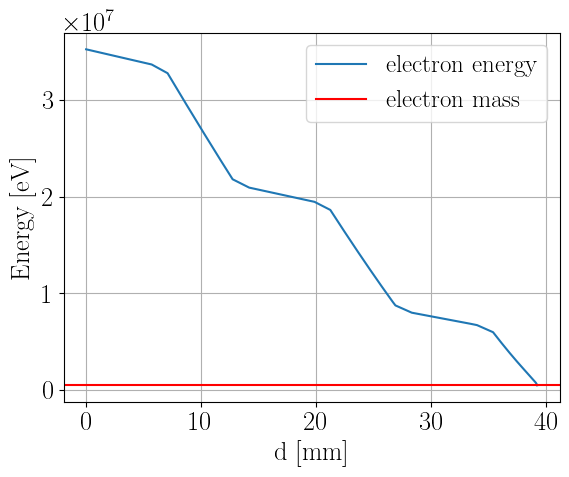

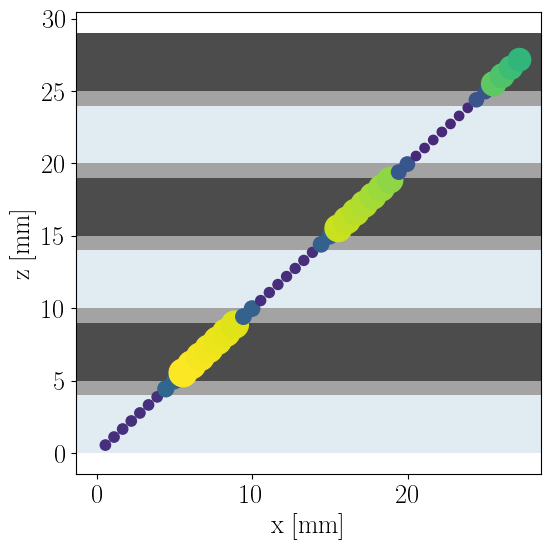

In [32]:
# Run
energies,x = propagation(electron,detec)

d = np.zeros((len(x),))
for i in range(1,len(x)):
    d[i] = d[i-1]+np.linalg.norm(x[i]-x[i-1])

plt.plot(d,energies, label="electron energy")
plt.axhline(electron.mass,color='r', label="electron mass")
plt.xlabel("d [mm]")
plt.ylabel("Energy [eV]")
plt.grid()
plt.legend()
plt.savefig("bethe_bloch_E_d_diag.eps", bbox_inches = 'tight')
plt.show()

fig, ax = plot_visual(energies,x)
fig.savefig("bethe_bloch_visual_diag.eps", bbox_inches = 'tight')
plt.show()


In [50]:
angles = np.linspace(0,np.pi/2,100)
d = np.zeros((len(angles),))

mass_mu = 105.7*10**6
charge = -1
mass_e = 511000
energy_e = mass_mu/2

for i,angle in enumerate(angles):
    electron = Particle(charge,mass_e,energy_e,[0,2],angle)
    energies, x = propagation(electron,detec)
    if i == 61:
        energies_before = energies
        x_before = x
    if i == 62:
        energies_peak = energies
        x_peak = x
    d[i] = np.linalg.norm(x[-1]-x[0])

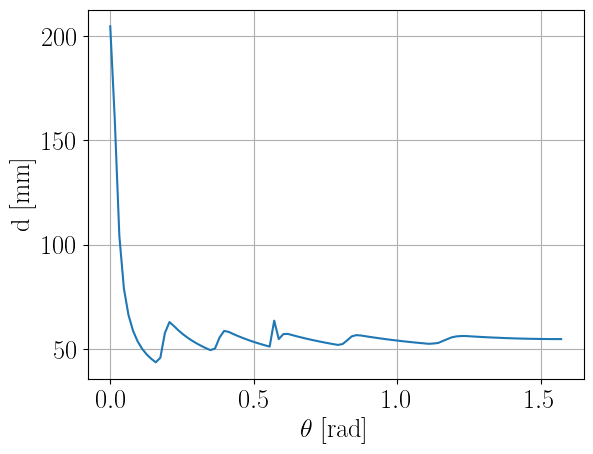

In [51]:
plt.plot(angles,d)
plt.xlabel(r"$\theta\ \mathrm{[rad]}$")
plt.ylabel("d [mm]")
plt.grid()
plt.savefig("bethe_bloch_d_angle_1_2.eps", bbox_inches = 'tight')
plt.show()

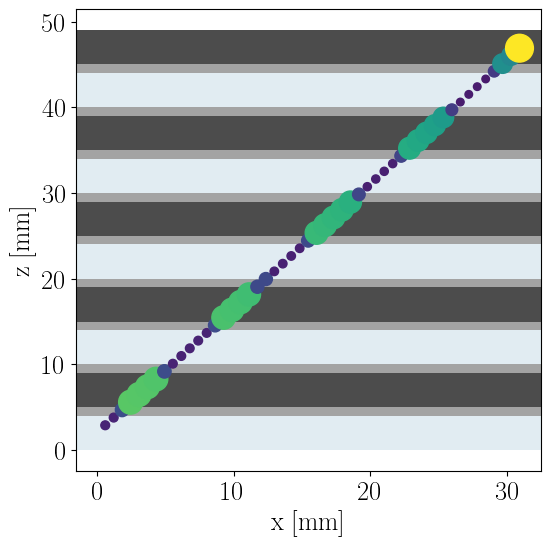

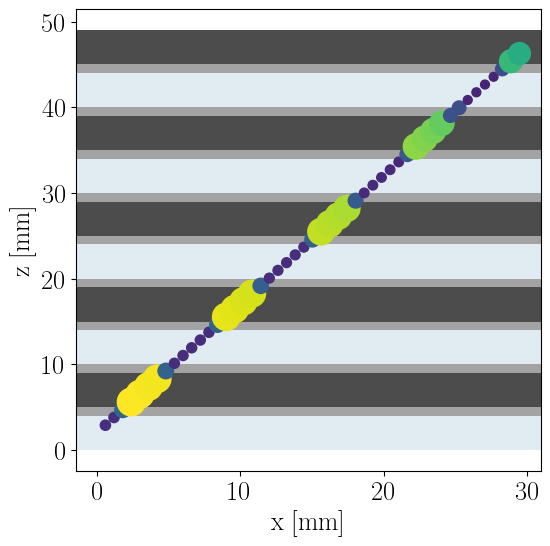

In [52]:
fig_before, ax_before = plot_visual(energies_before,x_before)
fig_peak, ax_peak = plot_visual(energies_peak,x_peak)